#### Algorithmic Trading - Optimizing strategy on back-testing using python

In this article I will describe code snippets on how to back-test trading strategies in python. This is a follow-up post to my previous article on backtesting a strategy in python, which I highly you to go through to understand this article. The motivation behind this article is to show how a single stragegy can be applied to various stock symbols with varying time periods (start and end dates) and code that encapsulates plotting and optimization techniques. 

This article covers two topics in particular.
1. Organizing code in an object oriented fashion
2. Optimizing strategy parameters to maximize returns

For simplicity, I will be basing the code snippets on a techical indicator based strategy (bollinger bands)

#### Here are the steps...
1. Download all necessary libraries
2. Create the Financial data class
3. Strategy class (Bollinger band based strategy)
4. Create the class obeject and back-test 
5. Create a tear sheet with pyfolio

In [4]:
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from itertools import product
import matplotlib.pyplot as plt
import warnings
import pyfolio as pf


In [5]:
class FinancialData:
    def __init__(self, symbol='TSLA', end=dt.datetime.today(), days=168):
        self.symbol = symbol
        self.start = end - pd.Timedelta(days=days)
        self.end = end
        self.retrieve_data(self.symbol, self.start, self.end)
        self.prepare_data()

    def retrieve_data(self, symbol, start, end):
        self.data = yf.download(symbol, start=start, end=end)

    def prepare_data(self):
        self.data['daily_returns'] = np.log(self.data['Adj Close'] \
                                    / self.data['Adj Close'].shift(1))
        self.data['bnh_returns'] = self.data['daily_returns'].cumsum()
        self.data.dropna(inplace=True)

    def plot_data(self, attribute_list):
        self.data[attribute_list].plot()
        plt.show()

    def plot_strategy_returns(self):
        self.plot_data(['bnh_returns', 'strategy_returns'])

    def create_simple_tear_sheet(self):
        pf.display(\
        pf.create_simple_tear_sheet(self.data['strategy_returns']))

In [6]:
class BollingerBandBacktester(FinancialData):
    def prepare_indicators(self, window):
        self.data['moving_avg'] = \
        self.data['Adj Close'].rolling(window=window).mean()
        self.data['moving_std'] = \
        self.data['Adj Close'].rolling(window=window).std()

    def backtest_strategy(self, window, start=None):
        self.prepare_indicators(window)
        self.data['upper_band'] = \
        self.data['moving_avg'] + 2 * self.data['moving_std']
        self.data['lower_band'] = \
        self.data['moving_avg'] - 2 * self.data['moving_std']

        if start is None:
            start = window

        # BUY condition
        self.data['signal'] = \
        np.where((self.data['Adj Close'] < self.data['lower_band']) &
                 (self.data['Adj Close'].shift(1) >= self.data['lower_band']), 1, 0)

        # SELL condition
        self.data['signal'] = np.where((self.data['Adj Close'] > self.data['upper_band']) &
                                       (self.data['Adj Close'].shift(1) <= self.data['upper_band']), -1,
                                       self.data['signal'])

        self.data['position'] = self.data['signal'].replace(to_replace=0, method='ffill')
        self.data['position'] = self.data['position'].shift()

        self.data['strategy_returns'] = self.data['position'] * self.data['daily_returns']

        performance = self.data[['daily_returns', 'strategy_returns']].iloc[start:].sum()

        self.data['strategy_returns'] = self.data['strategy_returns'].cumsum()
        return performance

    def optimize_bollinger_band_parameters(self, windows):
        start = max(windows)
        self.results = pd.DataFrame()
        for window in windows:
            perf = self.backtest_strategy(window=window, start=start)
            self.result = pd.DataFrame({'Window': window,
                                        'bnh returns': perf['daily_returns'],
                                        'strategy returns': perf['strategy_returns']}, 
                                         index=[0, ])
            self.results = self.results.append(self.result, ignore_index=True)
        self.results.sort_values(by='strategy returns', inplace=True, ascending=False)
        self.results = self.results.reset_index()
        self.results = self.results.drop("index", axis=1)
        print(self.results)

    def plot_optimized_bollinger_strategy_returns(self):
        if (len(self.results)) > 0:
            window = self.results.loc[0, 'Window']
            print("Window:", window)
            self.backtest_strategy(window=window)
            self.plot_strategy_returns()


[*********************100%***********************]  1 of 1 completed
    Window  bnh returns  strategy returns
0       40     0.117148          0.155962
1       12     0.117148          0.155962
2       42     0.117148          0.155962
3       11     0.117148          0.155962
4       41     0.117148          0.155962
5       39     0.117148          0.155962
6       36     0.117148          0.133771
7       27     0.117148          0.133771
8       28     0.117148          0.133771
9       29     0.117148          0.133771
10      30     0.117148          0.133771
11      37     0.117148          0.133771
12      38     0.117148          0.133771
13      32     0.117148          0.133771
14      33     0.117148          0.133771
15      34     0.117148          0.133771
16      35     0.117148          0.133771
17      31     0.117148          0.133771
18      23     0.117148          0.114483
19      26     0.117148          0.114483
20      24     0.117148          0.114483
21     

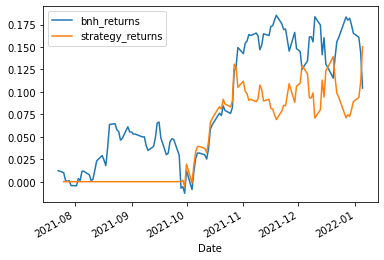

Start date,2021-07-23
End date,2022-01-05
Total months,5
,Backtest
Annual return,17816089.0%
Cumulative returns,26024.1%
Annual volatility,77.2%
Sharpe ratio,16.56
Calmar ratio,31481580.56
Stability,0.83
Max drawdown,-0.6%


None

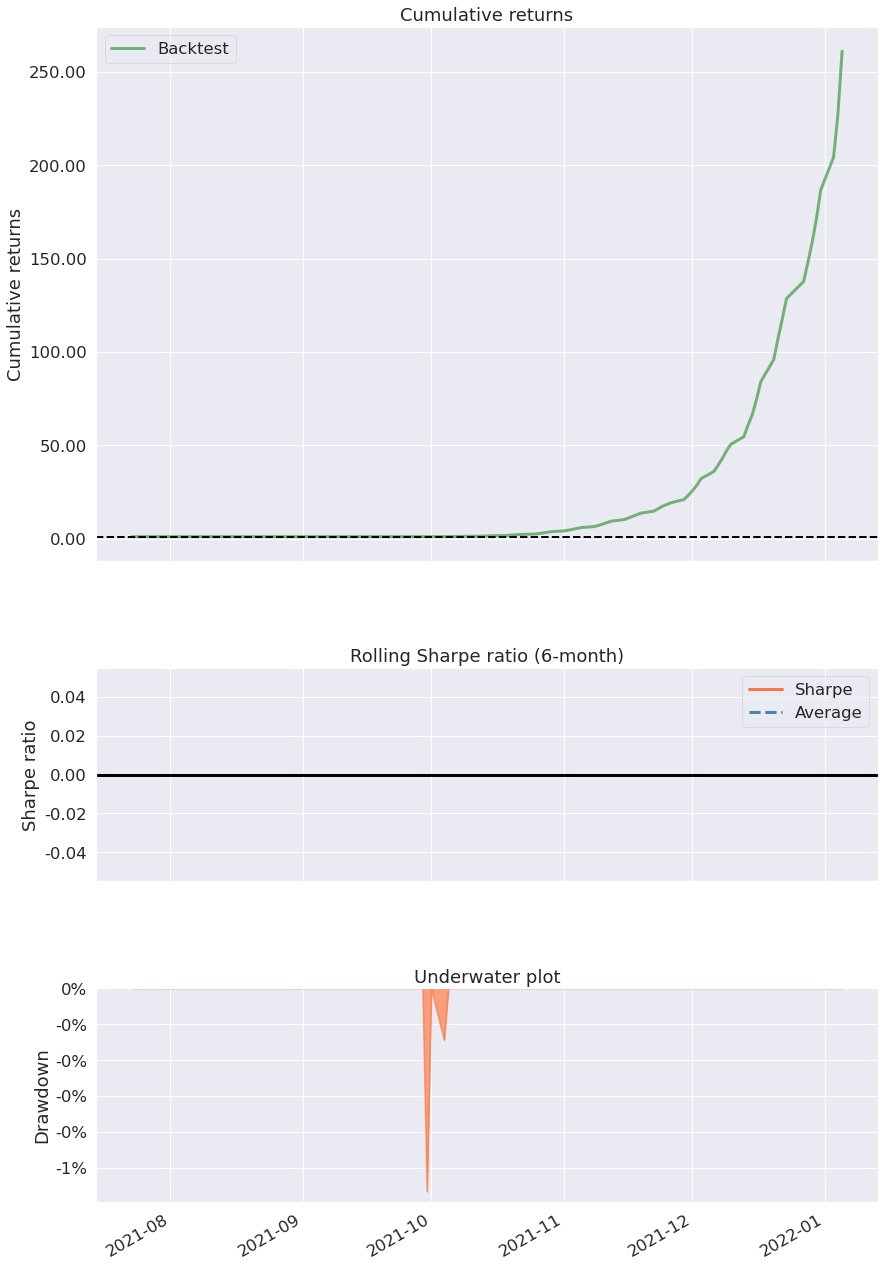

In [7]:
Bollinger = BollingerBandBacktester(symbol="MSFT")
Bollinger.optimize_bollinger_band_parameters(range(1, 50, 1))
Bollinger.plot_optimized_bollinger_strategy_returns()
Bollinger.create_simple_tear_sheet()